In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Ipynb_importer
from utils_x import *
from parameters_x import *
import seaborn as sns
sns.set(style="darkgrid")

importing Jupyter notebook from utils_x.ipynb
importing Jupyter notebook from parameters_x.ipynb


In [2]:
print("------------------- load data--------------------")
data = pd.read_csv('index500_v3_adjustment.csv')

print("------------------- limit_tag--------------------")
gb = data.groupby(['unique_symbol'])['adjustment_cumsum']
data['t+1_adjustment_cumsum'] = gb.transform(lambda x: x.shift(-1))
data["limit_tag"]  = (data["t+1_open"] - data["t+1_adjustment_cumsum"] + data["adjustment_cumsum"]) /data["close"] -1
data["limit_tag"] = data["limit_tag"].apply(lambda x: 1 if x >= 0.09 else 0)

------------------- load data--------------------
------------------- limit_tag--------------------


In [3]:
print("---------------- stationary pre--------------------")
data["r"] = data["close"]/ data["open"] - 1
data["amplitude"] = (data["high"] - data["low"]) / data["close"]
# data["amplitude_ratio"] = (data["high"] - data["low"]) / (data["close"] - data["open"])
# gb = data.groupby(['date_time'])['open']
# data['open_stationary'] = gb.transform(lambda x: (x-x.mean())/x.std())
# gb = data.groupby(['date_time'])['close']
# data['close_stationary'] = gb.transform(lambda x: (x-x.mean())/x.std())
# gb = data.groupby(['date_time'])['turnover']
# data['turnover_stationary'] = gb.transform(lambda x: (x-x.mean())/x.std())
# gb = data.groupby(['date_time'])['volume']
# data['volume_stationary'] = gb.transform(lambda x: (x-x.mean())/x.std())


gb = data.groupby(['date_time'])['open']
data['open'] = gb.transform(lambda x: (x-x.mean())/x.std())
gb = data.groupby(['date_time'])['close']
data['close'] = gb.transform(lambda x: (x-x.mean())/x.std())
gb = data.groupby(['date_time'])['turnover']
data['turnover'] = gb.transform(lambda x: (x-x.mean())/x.std())
gb = data.groupby(['date_time'])['volume']
data['volume'] = gb.transform(lambda x: (x-x.mean())/x.std())

print(data)
del data["Unnamed: 0"]
time_series = list(sorted(set(list(data.date_time))))
n_shift = 15
n_adjustment = []
for i in range(1,n_shift):
    n_adjustment.append("adjustment_cumsum"+str(i))

n_use_f = set(np.array(['unique_symbol', 'date_time', 't+1_open','t+2_open', 'return', 'label', 'rank_label', "use_tag", "adjustment"
                        ,'t+2_adjustment', "y_open", "adjustment_cumsum", 't+1_adjustment_cumsum']))
n_use_f = n_use_f | set(n_adjustment)
use_f = list(set(np.array(data.columns)) - n_use_f)
print(sorted(use_f))
print(len(use_f))

---------------- stationary pre--------------------
        Unnamed: 0  unique_symbol   date_time     close  turnover      open  \
0                2         600189  2010-01-29 -0.600878 -0.573116 -0.591930   
1                3         600190  2010-01-29 -1.068747 -0.588743 -1.056306   
2                4         600191  2010-01-29 -0.751355 -0.437039 -0.746722   
3                5         600192  2010-01-29 -0.451665 -0.560889 -0.444878   
4                7         600195  2010-01-29  1.183350  0.916641  1.113362   
...            ...            ...         ...       ...       ...       ...   
914174     4561421         300039  2017-12-27 -0.607294 -0.475564 -0.603361   
914175     4561425         300043  2017-12-27 -0.608527 -0.469235 -0.604578   
914176     4561435         300001  2017-12-27 -0.144313 -0.412997 -0.162283   
914177     4561436         300002  2017-12-27 -0.609144 -0.405373 -0.610662   
914178     4561481            960  2017-12-27 -0.202263  0.358325 -0.212170   


In [4]:
all_re = []
all_pre = []
all_real_label = []
all_market_return = []
all_te_time = []
all_turn = []
all_nums_p_return = []
all_nums_return = []
all_market_return_list =[]
all_limit_tag_list = []
all_time_list = []

data = data.dropna(how='any',axis=0) 
data = data[~data['return'].isnull()].copy()
print(len(data))
      
print("-------------------- train -----------------------")
for i in range(1):
    year = 2010+i
#     print(year)
#     tr_time = select_year(str(year), time_series) + select_year(str(year+1), time_series) + \
#               select_year(str(year+2), time_series) + select_year(str(year+3), time_series) + select_year(str(year+4), time_series)
#     te_time =   select_year(str(year+5), time_series) + select_year(str(year+6), time_series) + select_year(str(year+7), time_series)
    tr_time = select_year(str(year), time_series) + select_year(str(year+1), time_series) + select_year(str(year+2), time_series)
    te_time = select_year(str(year+3), time_series)
    fin_te_time = select_year(str(year+4), time_series)
    print(len(tr_time))
    print(len(te_time))
    print(len(list(set(tr_time)-set(te_time))))
    data_tr = data[data["date_time"].isin(tr_time)].copy()
    data_te = data[data["date_time"].isin(te_time)].copy()
    data_fin = data[data["date_time"].isin(fin_te_time)].copy()
    print(len(set(data_tr["date_time"])))
    print(len(set(data_te["date_time"])))
    X_train = data_tr[use_f]
    y_train = data_tr['label']
    X_test = data_te[use_f]
    y_test = data_te['label']

    market_return = list(data[data["date_time"].isin(list(data_fin.date_time))].groupby(['date_time'])['return'].mean())
    bst = train_op(X_train, y_train, params, num_rounds, X_test, y_test, early)  # 进行训练
    importance_dic = f_importance(bst, use_f)
    re, pre, real_label, turn, nums_p_return, nums_return, market_return_list, limit_tag_list, time_list = \
       simple_re_wheeled(data_fin, use_f, bst, version='long')
    
    all_re = all_re + re
    all_pre = all_pre + pre
    all_real_label = all_real_label + real_label
    all_market_return = all_market_return + market_return
    all_te_time = all_te_time + list(sorted(set(list(data_te['date_time']))))
    all_turn = all_turn + turn
    all_nums_p_return = all_nums_p_return + nums_p_return
    all_nums_return = all_nums_return + nums_return
    all_market_return_list = all_market_return_list + market_return_list
    all_limit_tag_list = all_limit_tag_list + limit_tag_list
    all_time_list = all_time_list + time_list
    print(len(all_turn))
    print(len(all_te_time))


906089
-------------------- train -----------------------
710
238
710
696
238


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-rmse:0.996887	eval-rmse:1.00344
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:0.963617	eval-rmse:0.969523
[2]	train-rmse:0.946433	eval-rmse:0.951879
[3]	train-rmse:0.937504	eval-rmse:0.942892
[4]	train-rmse:0.932626	eval-rmse:0.938106
[5]	train-rmse:0.929859	eval-rmse:0.935414
[6]	train-rmse:0.928198	eval-rmse:0.933892
[7]	train-rmse:0.92707	eval-rmse:0.933029
[8]	train-rmse:0.92638	eval-rmse:0.93245
[9]	train-rmse:0.92578	eval-rmse:0.932059
[10]	train-rmse:0.925201	eval-rmse:0.931793
[11]	train-rmse:0.924638	eval-rmse:0.931645
[12]	train-rmse:0.924236	eval-rmse:0.931416
[13]	train-rmse:0.923776	eval-rmse:0.931199
[14]	train-rmse:0.923402	eval-rmse:0.931118
[15]	train-rmse:0.922944	eval-rmse:0.930967
[16]	train-rmse:0.922485	eval-rmse:0.930813
[17]	train-rmse:0.922108	eval-rmse:0.930722
[18]	train-rmse:0.921798	eval-rmse:0.93062
[19]	train-rmse:0.921481	eval-rmse:0.

###############################################
[600261, 600195, 415, 600351, 600685, 600557, 600563, 600490, 600522, 600640, 600570, 600673, 600699, 600835, 600864, 600894, 601233, 50, 413, 541, 511, 636, 652, 669, 829, 822, 897, 997, 2028, 2008, 2005, 2152, 2277, 2281, 2293, 2332, 2315, 2396, 2400, 2368, 2410, 2429, 2508, 2698, 2557, 2574, 2663, 2635, 2638]
-0.006166223324699831 2014-01-10
[ 0.06206897 -0.0286113   0.00274725 -0.03177005 -0.019375    0.02449223
  0.00322135  0.01971326 -0.07090909  0.02300696 -0.01814301  0.00107527
 -0.03644915  0.02842704 -0.14368932 -0.03230543 -0.00892857 -0.04041204
 -0.01055556  0.01496259  0.01785714  0.         -0.00484262  0.00365691
 -0.01335312 -0.02461538 -0.00232019 -0.01021711  0.01408451 -0.00533537
 -0.00769231 -0.04029692  0.06122449  0.         -0.02183406 -0.00148368
  0.02643678  0.06981694 -0.0027248  -0.05125076  0.00934288 -0.05450734
  0.01518987  0.05693161 -0.02580645  0.00482859 -0.02985075 -0.03851333
  0.01456311]
#######

###############################################
[600320, 600183, 600158, 600162, 600366, 600284, 600280, 600333, 600335, 600482, 600469, 600397, 600551, 600121, 600120, 600640, 600740, 600773, 600884, 600880, 601100, 601339, 601311, 601678, 600872, 21, 49, 541, 719, 631, 683, 603, 732, 829, 962, 973, 2091, 2183, 2223, 2219, 2262, 2266, 2325, 2416, 2414, 2429, 2419, 2678, 600525]
0.005980473711134119 2014-01-24
[ 0.0060423   0.01204819 -0.00368098  0.01129944  0.00518519  0.04950495
 -0.01990446 -0.01632653  0.05482304  0.01646091 -0.00126263  0.01526718
  0.02619048  0.          0.0090312   0.01315193  0.05756579 -0.00555556
  0.00153728  0.05815062 -0.02252252 -0.00408163 -0.01618705  0.
  0.03043478  0.03807947 -0.00562041 -0.02244898 -0.00373692  0.00694444
 -0.0080429  -0.00577558 -0.01010101 -0.03617021 -0.009       0.
  0.01092498  0.03333333  0.02925244  0.02920255 -0.00369004 -0.01098901
 -0.07692308 -0.015       0.00940695  0.01508485  0.01678184  0.00645161
  0.02790698]
####

###############################################
[600094, 600180, 600184, 600110, 600038, 600161, 600026, 600280, 600223, 600284, 600487, 600704, 600570, 600551, 600640, 600594, 600770, 601002, 601208, 601216, 601519, 600880, 413, 21, 49, 78, 66, 566, 732, 786, 738, 719, 921, 997, 2013, 2122, 2153, 2315, 2262, 2293, 2416, 2410, 2447, 2508, 2701, 2498, 2489, 2493, 2572]
0.02112923708623957 2014-02-14
[-0.01492537  0.03751914  0.02521823  0.01098901  0.02859135 -0.00140977
  0.01141553  0.04511834  0.          0.03649001  0.03207547  0.04897959
 -0.00873965  0.01534884  0.02953586  0.0503792   0.09893993 -0.00923788
  0.00363636  0.01763908  0.03680982 -0.00204082  0.03636364  0.01481481
 -0.00269008  0.00770218  0.03125    -0.01776199 -0.00721649  0.00612745
  0.05430566  0.01591896  0.02631579  0.03007916  0.06178764  0.01635514
  0.00339271  0.0342339   0.          0.01551418  0.01385165  0.08456132
  0.00153061  0.0218108  -0.00580046  0.02341137  0.03763441  0.00827423
  0.03123373]


###############################################
[600054, 600086, 600158, 600261, 600401, 600240, 600195, 600335, 600584, 600640, 600645, 600743, 600773, 600787, 600850, 601388, 66, 566, 587, 550, 600880, 671, 655, 823, 829, 887, 939, 988, 927, 977, 987, 2056, 2063, 2049, 2152, 2191, 2183, 2179, 2249, 2292, 2340, 2368, 2440, 2437, 2461, 2503, 2690, 600517, 600531]
0.016878290335828074 2014-02-28
[ 0.00832639 -0.0330903  -0.00115207  0.02012195  0.05347594  0.02546296
 -0.00982456  0.01152436  0.01149425  0.02553626  0.0507053   0.0077821
  0.01456816  0.02709163 -0.00143472  0.03549061  0.0047619   0.02144772
 -0.01644245  0.02850877 -0.00144718 -0.00547945  0.00438596 -0.03513514
 -0.02926829  0.01423488  0.04409673  0.03259604  0.01069519  0.02026266
  0.02725367  0.0751269  -0.00409091 -0.00361174  0.042       0.04510451
  0.0109356   0.00353982  0.01609517  0.02424242  0.01769912  0.08959538
  0.04425711  0.00636653  0.01119403  0.01130856  0.02352941  0.04198669
  0.00520833]
#####

###############################################
[2678, 600121, 600078, 600223, 600158, 600312, 600322, 600410, 600392, 600468, 603001, 600533, 600570, 600628, 600858, 600657, 600651, 600702, 600699, 600826, 600869, 600884, 601000, 601216, 601636, 418, 540, 559, 919, 631, 671, 680, 697, 712, 897, 988, 2091, 973, 2078, 2075, 2123, 2219, 2396, 2306, 2342, 2414, 2424, 777]
0.029350410890987288 2014-03-14
[ 0.03176471  0.01814059  0.00367647  0.0057971   0.03584672  0.04566929
  0.          0.04054054 -0.009375    0.02325581  0.00848564  0.00666667
  0.09991533  0.03512623  0.00762195  0.03498542  0.0496988   0.02323651
  0.05478261  0.01182197 -0.02332362  0.07988166  0.00666667  0.02888087
  0.01188904  0.0212766   0.00798403  0.04744186  0.12        0.018
  0.01125     0.00694444  0.02922078  0.0070922   0.01016949  0.03651987
  0.0560054   0.04571429  0.03081232  0.01871102  0.04150943  0.07631231
  0.04575163  0.0234375   0.01365188  0.05108696  0.05331705  0.00495868]
################

###############################################
[600094, 600078, 600645, 600162, 600171, 600618, 600322, 600409, 600366, 600563, 600639, 600651, 600699, 600748, 600776, 600787, 600825, 600826, 600884, 600894, 600983, 601000, 601965, 6, 78, 510, 511, 541, 559, 616, 631, 671, 732, 2004, 2022, 2153, 2152, 2285, 2292, 2309, 2315, 2325, 2342, 2345, 2396, 2440, 2463, 2635]
-0.008057963153135976 2014-03-28
[-0.02554745  0.00362319 -0.02928199  0.00689655 -0.00383142 -0.07482993
 -0.02493075 -0.01212121  0.00544218  0.02224053 -0.04295051 -0.07909605
  0.02673797 -0.03733333 -0.03091061  0.01055807 -0.05543478 -0.02516556
  0.017067   -0.0100077  -0.00953778  0.01495726 -0.05142857 -0.01291513
 -0.01468788 -0.01785714 -0.00773694  0.05112474  0.00421941 -0.0297619
  0.00988142  0.03162486  0.03108808 -0.01788806 -0.00542741 -0.05563218
  0.02662037 -0.02513966  0.03400204 -0.01001112 -0.00428894 -0.00659341
 -0.01246106  0.01131222 -0.02631579  0.06227106 -0.01404494  0.01672003]
#############

###############################################
[600067, 600112, 600122, 600162, 600223, 600289, 600460, 600397, 600239, 600533, 600545, 600618, 600673, 600683, 600747, 600743, 600759, 600826, 600869, 600983, 600729, 603077, 418, 511, 513, 550, 540, 559, 608, 620, 671, 697, 719, 823, 951, 2048, 2075, 2161, 2194, 2292, 2293, 2305, 2320, 2325, 2340, 2410, 2572, 2698]
0.0145388271290852 2014-04-11
[-0.00325203  0.03308824  0.00970874  0.00347222  0.          0.0172043
  0.01072386  0.0325      0.02096436 -0.0031348   0.11888112  0.00129032
  0.04382826  0.00952381 -0.01433692  0.01775148 -0.00795053  0.00123457
  0.01807229 -0.00199601  0.01696429 -0.00404858 -0.00306748  0.0626087
 -0.01138805  0.01506741  0.00362319  0.06495883  0.00913242  0.08726753
 -0.00323625 -0.0089141   0.00754717  0.03079555  0.00497512  0.02030869
  0.00457666  0.00416667 -0.0098912  -0.02365978 -0.00854317 -0.0056338
  0.01190476  0.02904564  0.01363636  0.01981506  0.05542453  0.00685426]
####################

###############################################
[601929, 42, 600885, 600872, 566, 559, 511, 2690, 2678, 620, 2118, 877, 601000, 935, 2152, 2049, 600158, 600139, 600180, 600110, 600094, 600325, 600333, 600425, 600397, 600487, 600460, 600522, 600545, 600587, 600639, 600618, 600614, 600740, 2371, 2396, 2203, 2273, 2194, 2191, 2308, 2419, 600270, 2477, 2470, 2292, 2635, 2534]
-0.026846992299360124 2014-04-24
[-0.01692184 -0.03015941 -0.02519763 -0.0107949  -0.01809524 -0.08466135
 -0.10590278 -0.07262693 -0.02743142 -0.05499276 -0.00990099 -0.02120718
 -0.05       -0.00181488 -0.01537585 -0.04561569  0.00193798 -0.01050788
 -0.02590674 -0.07632094 -0.00643087 -0.00430416 -0.01264045 -0.05963303
 -0.00735294  0.01360863 -0.01416431 -0.01923077 -0.04030227 -0.03378009
 -0.02651839 -0.0198939  -0.02898551 -0.02443281  0.0004995  -0.01047577
 -0.02401922 -0.00584795 -0.05749293 -0.0289548  -0.05224964 -0.01425856
 -0.01315789 -0.00631579 -0.02905199 -0.02196721  0.0002963  -0.04010239]
#######

###############################################
[600183, 600069, 600088, 600139, 600121, 600387, 600392, 600429, 600456, 600468, 600611, 600640, 600596, 600702, 600729, 418, 600773, 600787, 601000, 601011, 601216, 550, 426, 501, 413, 541, 620, 636, 688, 921, 962, 973, 988, 2048, 2254, 2285, 2378, 2392, 2414, 2428, 2430, 2477, 2493, 2490, 2648, 2663, 2635]
0.03388319335796669 2014-05-09
[0.03508772 0.02393617 0.01995723 0.05754717 0.09855769 0.00584368
 0.04567308 0.02384292 0.08198121 0.03634578 0.00436047 0.03106796
 0.02164502 0.02962963 0.01888531 0.03277061 0.01675978 0.00545596
 0.00452489 0.03383085 0.02598653 0.02826855 0.19642857 0.00470588
 0.00618648 0.02       0.08305085 0.01604278 0.042      0.01980198
 0.0862069  0.00210526 0.00870647 0.05676516 0.01843318 0.00496102
 0.0679975  0.01083032 0.03557047 0.09669211 0.02225755 0.00497512
 0.00858896 0.0310559  0.02362205 0.0189166  0.02465078]
###############################################
[600180, 600183, 600138, 600151, 6001

###############################################
[600059, 600064, 600132, 600026, 600197, 600184, 600268, 600311, 600401, 600425, 600468, 600521, 600587, 600618, 600651, 600724, 600723, 600776, 600885, 600880, 601002, 603001, 66, 42, 49, 510, 712, 669, 919, 951, 997, 2008, 2028, 2181, 2190, 2223, 2249, 2275, 2308, 2309, 2345, 2400, 2396, 2405, 2410, 2424, 2414, 2508]
0.01965574735098271 2014-05-22
[ 0.00849515  0.00583658  0.00852878  0.01219512  0.01196953  0.00674049
  0.0019685  -0.00425532  0.01206434  0.02574257  0.03523316  0.00097466
  0.03278689  0.02448454  0.01269841  0.01900238  0.02113821  0.02308326
  0.01522843  0.01634615  0.01660281 -0.00290909  0.05974026  0.00821543
  0.01783591 -0.00158983  0.00154083 -0.0272962   0.01724138  0.03225806
  0.06376057  0.02939375 -0.0030581   0.01570997  0.09995903  0.03011094
  0.0642978   0.01583113  0.00585652  0.03246014  0.02541296  0.01923077
  0.04751712  0.05        0.02177752  0.00418216  0.0078125   0.0013197 ]
###############

###############################################
[600054, 600037, 600171, 600158, 600240, 600270, 600289, 600322, 600468, 600551, 600517, 600482, 600563, 600392, 600640, 600587, 600757, 600750, 600801, 600835, 600831, 600884, 600983, 601011, 601208, 601801, 601999, 603001, 601965, 30, 42, 732, 2123, 2048, 2191, 2267, 2292, 2315, 2393, 2410, 2424, 2396, 2482, 2480, 2489, 2493, 2690, 2701]
-0.004765591759979699 2014-06-05
[ 0.00258176 -0.01957295 -0.01979167 -0.00364964  0.01336303 -0.0073831
 -0.00930233 -0.00914634  0.02150538 -0.02503129 -0.00909091 -0.00803213
  0.01239669 -0.00985829  0.02833333  0.04196816 -0.02080925 -0.00705128
 -0.01788909  0.00904393 -0.02307692 -0.0156038  -0.01213961  0.03241182
 -0.00440529 -0.01288245 -0.01223242  0.00146306 -0.01240695 -0.0063593
 -0.01420217 -0.01285047  0.00547196 -0.01357466 -0.00072098 -0.00843882
 -0.00204738  0.00149925 -0.00867453 -0.02167208  0.00541667 -0.00983091
 -0.0147662   0.01414427 -0.01632653 -0.03055229  0.00661871 -0.0055

###############################################
[600158, 600551, 600587, 600580, 600298, 600311, 600067, 600037, 600063, 600511, 600438, 2662, 600654, 600525, 600759, 600704, 513, 488, 600790, 601002, 601208, 600198, 603, 601999, 550, 552, 829, 2414, 788, 738, 2048, 2078, 712, 2122, 2181, 2179, 2194, 2262, 2266, 2368, 2396, 2405, 2574, 2444, 2490, 2480, 997, 977]
-0.02941356531675725 2014-06-18
[-0.04526316 -0.08004926 -0.03988996 -0.01583113 -0.01749475  0.01918977
 -0.02251407 -0.03846154 -0.02788845 -0.03975678  0.0056243  -0.05735661
 -0.01560758 -0.02838828 -0.02242152 -0.00858896 -0.00562162 -0.0212766
 -0.06164384 -0.00990099 -0.04727794 -0.0684661   0.         -0.00409836
 -0.03576438 -0.02871411 -0.05057471 -0.04294118 -0.09687906 -0.02707276
 -0.04798871 -0.02931596 -0.02609263  0.02739726 -0.05125    -0.01272727
 -0.03245614 -0.00184162 -0.01867816 -0.03357532 -0.03166421 -0.03870162
  0.02040816 -0.02723312 -0.04705882 -0.00719424 -0.04831199 -0.07063712]
##################

###############################################
[600037, 600329, 600201, 600054, 600699, 600517, 600511, 2678, 600645, 600563, 600566, 600651, 600425, 600654, 600398, 600737, 600776, 600747, 600879, 601126, 601388, 601519, 600184, 28, 506, 426, 543, 603, 603077, 655, 587, 688, 693, 697, 759, 2069, 919, 930, 2025, 2048, 2242, 2267, 2271, 2414, 2384, 2534, 2698, 2489, 2479]
0.01282680355758199 2014-07-01
[ 0.00272727 -0.01830065 -0.01092044 -0.00078493  0.01071565  0.04296875
  0.         -0.03376906  0.0140411   0.00151515  0.          0.01388889
  0.0186722   0.02120536 -0.00328947  0.00823045 -0.00560897  0.01253918
  0.00594228  0.00608519 -0.00050469 -0.01751592  0.03357207  0.02631579
  0.02798982  0.01956746  0.00761035  0.05991903  0.03325599  0.02308802
  0.00185701  0.05142857  0.03621399  0.11717613 -0.0037831   0.00135685
 -0.00144404  0.01061008  0.00508582  0.03219178 -0.00970874  0.01075269
  0.01449275  0.06779661 -0.01671583 -0.0238806  -0.00687023  0.0403071
  0.0024906

###############################################
[600139, 600587, 600292, 600329, 600481, 600478, 600467, 600496, 600517, 600511, 2646, 600639, 600557, 600389, 600825, 600761, 600699, 600850, 600851, 601311, 601636, 600335, 30, 426, 596, 601965, 688, 823, 2309, 788, 2063, 2069, 2091, 2052, 2048, 2123, 2154, 2179, 2204, 2285, 2384, 2358, 2414, 2573, 2534, 2714, 2424, 2701, 2005]
0.007966792315346829 2014-07-14
[ 0.00547945 -0.00605288 -0.01372549  0.03441156 -0.00802407  0.02056075
 -0.00556586  0.00588235  0.02220077  0.03232759  0.01329956  0.02750491
 -0.01272727  0.          0.00611247  0.01019462 -0.02680867  0.07450077
 -0.00137741  0.00528634  0.00968188 -0.02147971 -0.02714286 -0.02027748
  0.04873294  0.0233871   0.09969789  0.00728745  0.02256851 -0.01382488
  0.01252134  0.01110385 -0.01799007 -0.01058824  0.00700191 -0.01113861
  0.02020202 -0.00974553  0.05882353  0.0052356  -0.01506024  0.01818182
 -0.01159981 -0.01144414 -0.03991292  0.01818182  0.06172414 -0.01342975
  0.

###############################################
[600094, 600161, 600580, 600329, 600054, 600268, 600545, 600468, 600511, 2646, 600618, 600563, 600566, 600673, 600432, 600429, 600654, 600651, 600645, 600640, 600401, 511, 600850, 600787, 600983, 600740, 601388, 50, 66, 21, 848, 777, 2063, 2025, 2013, 2190, 2285, 2342, 2345, 2254, 2368, 2414, 2378, 2498, 2428, 2698, 975, 997]
0.021536955767498107 2014-07-25
[ 0.          0.01321586  0.01931818  0.00632911  0.00076394  0.01631321
  0.01        0.01651376  0.01029083  0.0060241   0.03026482  0.0157754
  0.0004995   0.0052356   0.05503356  0.03448276  0.01109878  0.02564103
  0.01952055  0.02964793  0.02372035  0.05433526  0.04414261  0.05044921
  0.03746398  0.01408451  0.02050663  0.0609319   0.02649007  0.01692047
  0.02701299  0.02662116  0.02599653  0.04945718  0.02581072  0.04892857
 -0.02004219  0.0017762   0.00117925 -0.00328587  0.00430339  0.02564103
  0.03061224  0.00689655  0.0362426   0.02597995  0.03133641  0.01429328]
########

###############################################
[600088, 600584, 600184, 600175, 600468, 600517, 2662, 600487, 667, 600429, 600397, 541, 600759, 600773, 600816, 600850, 600826, 600787, 600820, 600754, 600879, 600869, 600885, 601010, 600967, 601233, 66, 601801, 601777, 600239, 603766, 31, 550, 616, 603, 762, 693, 688, 927, 732, 2029, 2025, 2118, 2267, 2276, 2588, 2678, 2489, 2477]
0.011900976750366533 2014-08-07
[ 0.01865672  0.001002    0.00884956  0.06386293  0.00353669  0.01388889
  0.01698514  0.01449275 -0.00483092  0.00889454 -0.025       0.01740812
  0.01163832 -0.0048     -0.00460035  0.05498564  0.02255193  0.03191489
  0.         -0.00283286  0.02325581  0.07924922  0.01097454  0.00416667
  0.04169515 -0.01183432  0.06827309  0.02054795 -0.01108647  0.
  0.01226994 -0.00398406 -0.00879321  0.0056338  -0.01131626  0.0592686
 -0.02858362 -0.00141844  0.04845815  0.01541624  0.          0.01186178
  0.00562588  0.021      -0.00941176  0.00237436  0.01254276  0.00345722
 -0.023099

###############################################
[600141, 600037, 600088, 600110, 600094, 600184, 600183, 600175, 600054, 600280, 600551, 600536, 600525, 600517, 2424, 600702, 600628, 600704, 600640, 600410, 600765, 600803, 600797, 600894, 601011, 601636, 601880, 601777, 510, 540, 603077, 612, 697, 762, 823, 2092, 848, 927, 2050, 2118, 2190, 2225, 2325, 2273, 2392, 2477, 2004, 987]
0.008763676144687092 2014-08-20
[ 0.0066778   0.03350515  0.07784431  0.00158479 -0.00260417 -0.01542324
 -0.013947   -0.01639344  0.06245461  0.00827967  0.09051254  0.00227187
 -0.01820941 -0.0041841  -0.00457666  0.02116788  0.04371585  0.00520833
  0.0279686   0.01492537  0.06510417 -0.02048558  0.00636943 -0.00290487
  0.00167926 -0.00520833  0.00636943 -0.02620087 -0.00936768  0.01820728
 -0.01253133  0.09988777  0.00636943 -0.02712477  0.00833333 -0.00508259
 -0.01686183 -0.03732809  0.02406015 -0.04704463 -0.00177419  0.07244318
  0.00526316 -0.02271605  0.03842459 -0.0025641  -0.00396825 -0.01147028]

###############################################
[600162, 600158, 600017, 600618, 600325, 600171, 600525, 600500, 600511, 600507, 2662, 2612, 600490, 600487, 600482, 600488, 2646, 600702, 600566, 600580, 600418, 600438, 600410, 600736, 600844, 600754, 600759, 600820, 600879, 600765, 601311, 88, 603366, 759, 823, 2064, 927, 2032, 2204, 2219, 2305, 2275, 2396, 2424, 2572, 2574, 2534, 2444]
0.009849782275909526 2014-09-02
[ 0.00957854  0.14141414 -0.02769231  0.01524033  0.02380952  0.01074219
 -0.00560448  0.00381194 -0.01210938  0.01591512  0.05295675 -0.06468254
  0.08715252  0.00408401  0.02871148  0.04863813 -0.00058548  0.01041667
 -0.00795404  0.00440529 -0.00298285 -0.00099108 -0.00504323  0.00242718
  0.01512859  0.00096805 -0.00668338  0.00507614 -0.01436031  0.00555247
  0.04651163 -0.03547297  0.0540721   0.00946746 -0.00878477  0.00097752
  0.00392157  0.00512164 -0.00256849  0.00347977  0.01092044 -0.01171875
  0.          0.00790167  0.01224707  0.00088028  0.01376812  0.024

###############################################
[600139, 600094, 600169, 600004, 600017, 600039, 600037, 600268, 600337, 600260, 600198, 600510, 600468, 600537, 600507, 600496, 680, 600580, 600639, 600432, 600439, 600651, 600747, 600743, 600765, 600831, 600815, 600869, 601616, 601515, 601718, 601908, 600240, 506, 603077, 667, 887, 697, 861, 809, 829, 2018, 2052, 2405, 2285, 2595, 2463, 2490]
0.013507053898016578 2014-09-16
[-0.02201071 -0.02258469  0.00249377  0.00628141  0.05074627 -0.00936768
  0.00143885  0.01828411  0.01455026  0.1         0.0689259  -0.00277008
  0.03340926  0.01248439 -0.01869159 -0.00358852  0.1212938   0.01861427
  0.01046699 -0.00323415  0.04883721  0.01482326 -0.00590842  0.03478261
 -0.01588703  0.04361702  0.00363636 -0.02790698  0.00404858 -0.0034188
  0.04469274 -0.01979167  0.03675345  0.0362069  -0.0093361   0.0375
  0.03766334 -0.02377261 -0.00377358  0.02517753  0.00106045  0.02829162
 -0.01438159  0.01260126 -0.00723982 -0.0180531   0.01044386  0.000

###############################################
[600006, 600612, 600110, 600289, 600251, 600468, 600510, 600389, 600490, 600500, 600572, 600566, 600422, 600651, 600729, 600816, 600815, 600844, 600971, 601011, 601100, 601311, 601777, 603766, 655, 510, 631, 777, 861, 2028, 2073, 2083, 2032, 2315, 2153, 2194, 2305, 2293, 2277, 2281, 2384, 2396, 2392, 2574, 2444, 2480, 2489, 2714]
0.00987818019426629 2014-09-29
[ 0.03783784 -0.00793126  0.01793103  0.00644567 -0.01139896 -0.00714796
 -0.01869159 -0.00986133  0.00588235 -0.00124844  0.01679664  0.00205761
 -0.00498753  0.003367    0.00133571  0.0546686   0.0214168   0.00686813
 -0.02698864 -0.01285141  0.02246181  0.00529101  0.02282609  0.01204819
 -0.0012285   0.00485437 -0.00162602 -0.01623377  0.0822695   0.00084388
  0.03166667  0.         -0.00255428  0.00628931  0.10004275  0.
  0.0227596   0.00866694 -0.01609058  0.00421836  0.03825137 -0.00563474
 -0.00087796 -0.00422654  0.00460829  0.02931596  0.01096491  0.04174573]
############

###############################################
[600038, 600161, 600160, 600200, 600184, 600056, 600351, 600557, 600545, 600380, 600387, 2678, 2690, 600482, 600488, 600601, 600425, 600812, 600765, 600759, 600815, 600993, 601718, 78, 650, 652, 559, 566, 627, 667, 732, 777, 780, 735, 852, 919, 2018, 2049, 2048, 2041, 2128, 2168, 2179, 2183, 2251, 2285, 2405, 2479]
0.017221384718094625 2014-10-17
[-0.00952381  0.00374532  0.00308642  0.03291536  0.00608828  0.02054292
  0.00389105  0.00104457  0.00770925  0.01449275 -0.008      -0.02409639
  0.05128205  0.00694444  0.01008403  0.00627615  0.00344828 -0.00280899
 -0.01069959  0.01270417  0.08503401  0.01098901  0.01002004 -0.00952381
  0.00972222  0.06666667  0.01627219  0.01193182  0.02419355 -0.00353357
  0.03726708  0.00677966  0.00385356  0.          0.00906843  0.0359322
  0.08226691  0.03645506 -0.0182783   0.0262765   0.01187648  0.06622517
  0.08151093  0.02797203  0.0066305   0.02406832  0.03448276  0.00334076]
###################

###############################################
[600151, 600158, 600004, 600325, 600064, 697, 693, 600508, 600416, 600736, 600755, 600894, 600776, 600805, 600850, 600888, 600967, 601099, 601208, 601369, 601608, 601777, 601801, 600790, 603077, 99, 66, 600239, 671, 506, 688, 2662, 816, 861, 927, 919, 2073, 2063, 777, 2122, 935, 2221, 2262, 2251, 2204, 2479, 1696]
0.0006656487767886166 2014-10-30
[-0.01933702 -0.02994386  0.03583427  0.02699229 -0.01486486 -0.03640553
  0.00233209  0.02527806 -0.00929054  0.          0.05343511 -0.01052632
  0.00502513  0.02420857 -0.0494732  -0.00566572 -0.02271252  0.00703235
  0.01337449  0.02058824 -0.0095057   0.01        0.02004582  0.00249377
 -0.00294406 -0.00497512  0.         -0.01384083  0.02380952  0.00561798
  0.00985915  0.01557632 -0.04185351 -0.00932401  0.01652893  0.
  0.00676183 -0.0111836   0.01516634 -0.02394366  0.01210287  0.0267335
 -0.02027491 -0.03672316 -0.03803487  0.04502618  0.01828571]
#######################################

###############################################
[600038, 600636, 600251, 600270, 600280, 600397, 2698, 600612, 600439, 600432, 600467, 600826, 600850, 600864, 600894, 601000, 601100, 601339, 601515, 601678, 601880, 601908, 600239, 426, 99, 543, 688, 636, 501, 655, 652, 780, 886, 1696, 2128, 2293, 2320, 2368, 2309, 2430, 2444, 2480, 2572, 2551, 2663, 2498, 2714]
-0.007442990074065971 2014-11-12
[-0.02378976 -0.05109489  0.01203501 -0.03221649 -0.01674009 -0.03096539
 -0.02394107  0.02407596 -0.01652893  0.00852273  0.0201005  -0.00930487
 -0.00097752 -0.0031746   0.00625     0.01615799 -0.02610114 -0.0061792
  0.0035524  -0.01670379 -0.05982906  0.0033195  -0.00327869  0.02287283
 -0.04788732  0.00835322  0.02216066 -0.01293661 -0.01315789  0.01745636
  0.00343053  0.00573614 -0.0172043  -0.03214696 -0.00118203 -0.02647658
  0.0026362   0.01195652 -0.00590446  0.00123457 -0.01833461 -0.00630631
 -0.03378675 -0.00719683 -0.00364166 -0.02        0.02731614]
###############################

###############################################
[600026, 600628, 600176, 600054, 600398, 600410, 600563, 600657, 600639, 600611, 600724, 600429, 600572, 600438, 600435, 600428, 600963, 600823, 600864, 601099, 601566, 31, 603555, 543, 552, 563, 631, 671, 620, 786, 732, 809, 850, 900, 979, 2345, 2203, 2191, 2216, 2244, 2325, 2320, 2358, 2342, 2480, 2635]
0.009868806878163746 2014-11-25
[-0.01708075 -0.00636943  0.0255418   0.01449275  0.00742804  0.00358423
  0.00544872  0.00444444  0.00874453  0.01628664  0.01265823  0.01578354
 -0.00613497 -0.00929752 -0.00559284 -0.02037037 -0.00733945 -0.00173611
  0.01898102  0.03139535  0.00534351 -0.00182482  0.00848057  0.05049396
  0.02357564  0.01128205 -0.00909091 -0.02474527 -0.01029412  0.03971292
  0.00082988 -0.01184539  0.04622496  0.03007519  0.0087146  -0.01336303
  0.14235294 -0.01274788  0.00727273  0.00413223  0.03457217 -0.00757576
 -0.01151832  0.01174743  0.0165426   0.02474937]
###############################################
[600

###############################################
[600125, 600169, 600141, 600337, 600280, 600289, 600507, 600500, 600521, 600723, 600724, 600449, 600425, 600683, 600743, 600765, 600748, 600750, 600770, 600879, 600815, 600835, 601126, 601369, 601678, 600251, 90, 418, 726, 809, 2122, 877, 997, 2073, 2153, 2152, 2181, 2216, 2221, 2285, 2183, 2309, 2305, 2419, 2444, 2662, 2663]
-0.030260521184964854 2014-12-08
[ 0.01889169 -0.0503937  -0.01857143 -0.03474903 -0.08169014 -0.04241877
 -0.00220264 -0.00898876 -0.05059338 -0.03095559 -0.02090592  0.02293578
 -0.05640244 -0.03181189 -0.02912621 -0.14290909  0.05545617 -0.03963964
 -0.03417085 -0.12146226  0.1        -0.04891304 -0.05826218  0.02657005
 -0.02222222 -0.02779156 -0.09906396  0.06220472  0.01038716 -0.04
 -0.10583942  0.07236062 -0.04651163 -0.05971277 -0.03466667 -0.03488969
 -0.00584795 -0.0362494  -0.0281294  -0.10851735 -0.08705701 -0.03157895
 -0.05263158 -0.02057613 -0.07927273 -0.06607275  0.09974747]
########################

###############################################
[600337, 600266, 600184, 600312, 600325, 600416, 600570, 600517, 600510, 2678, 600239, 600765, 600755, 601965, 600858, 600830, 601099, 601801, 603001, 31, 422, 415, 552, 550, 563, 559, 652, 501, 612, 685, 572, 759, 861, 897, 927, 930, 997, 977, 2153, 2183, 2271, 2315, 2371, 2392, 2430, 2534, 2503]
-0.05055829954362322 2014-12-19
[-0.02443793 -0.0845815  -0.00110988  0.02369077 -0.13653137 -0.03957997
 -0.08945687 -0.00729927 -0.05230386 -0.08900145 -0.06389302 -0.11431065
 -0.07016129 -0.08074534 -0.02587177 -0.11666667 -0.01791045 -0.02849003
 -0.07536077 -0.03341902 -0.01902174 -0.06837607  0.00377358 -0.01821731
 -0.02627258 -0.12350877 -0.08535032 -0.02012987 -0.07156863 -0.05638767
 -0.04814815 -0.00345622 -0.09       -0.11479592 -0.05571429  0.
 -0.04257603  0.1        -0.08988341 -0.07035519 -0.03396015 -0.09537705
 -0.03427347 -0.08364451 -0.01490826 -0.07091172 -0.01573604]
###############################################
[600026,

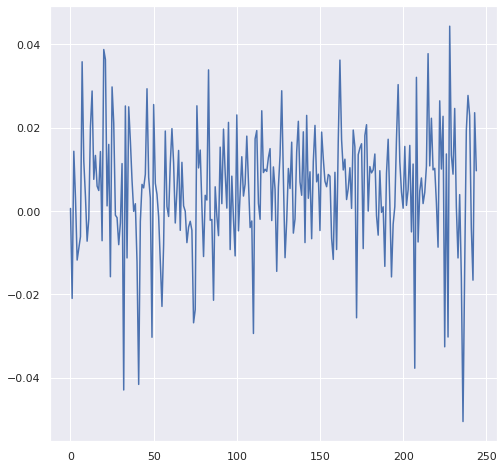

In [5]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(all_re)

In [6]:
def plot_conditional_expectation(x, y, quantile_n = 20):
    step = 1 / quantile_n
    bin_cut = np.percentile(x, list(np.append(np.arange(0,1,step), 1)*100) )
    bin_cut = np.unique(bin_cut)
    tmp = pd.DataFrame({'x':x.flatten(), 'y':y.flatten()})
    tmp['bin_cut'] = pd.cut(tmp['x'],bin_cut,include_lowest=True)
    groupby_mean = tmp.groupby('bin_cut').mean().reset_index()

    plt.figure(figsize=(12,4))
    plt.plot(groupby_mean['x'], groupby_mean['y'], '-o')
    plt.axvline(x=0, color='r', ls='-.')
    plt.axhline(y=0, color='r', ls='-.')
    plt.show()
        
    return groupby_mean

In [7]:
df_r =  pd.DataFrame({"real_nums_return":all_nums_return,\
                      "pre_nums_return":all_nums_p_return,"rank":all_real_label,\
                      "pre_rank":all_pre, "limit_tag":all_limit_tag_list,\
                      "market_return":all_market_return_list, "time_list":all_time_list})

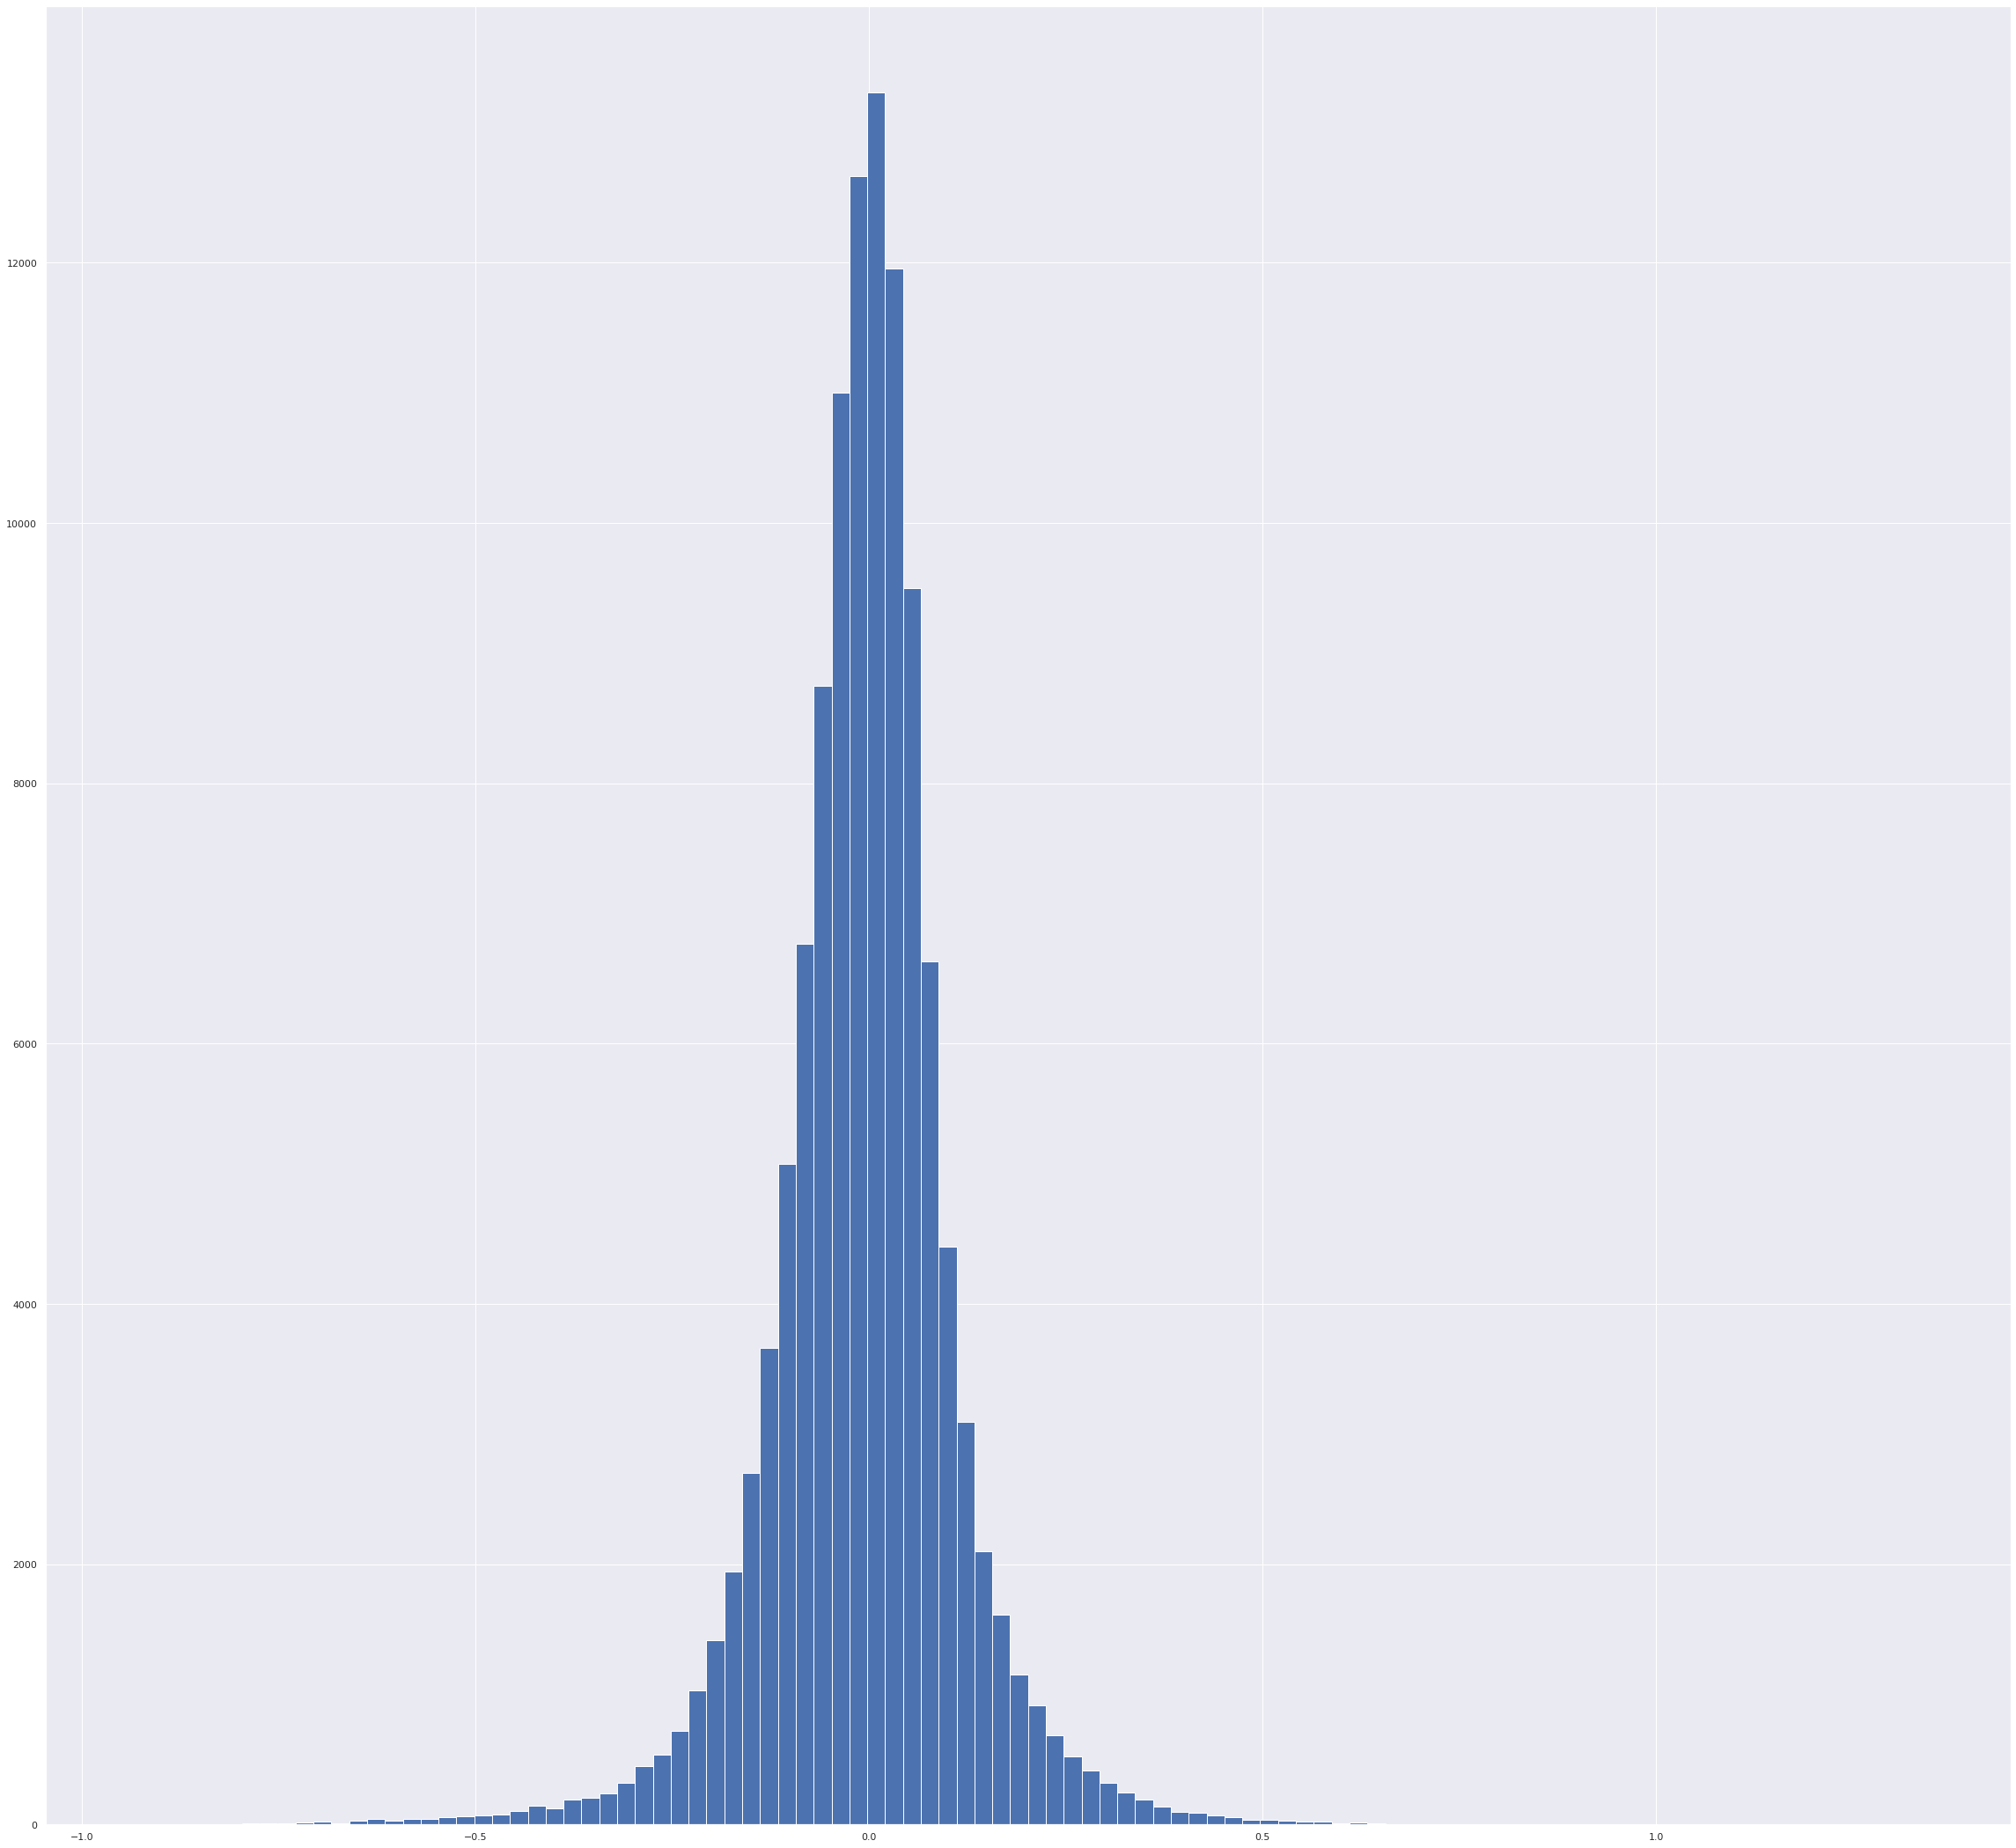

In [53]:
df_r["pre_nums_return"].hist(bins =100)

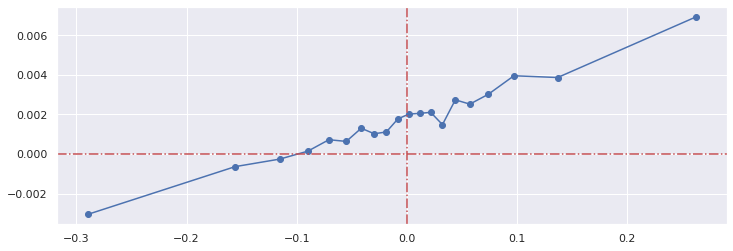

,bin_cut,x,y
0,"(-0.934, -0.187]",-0.289881,-0.003053
1,"(-0.187, -0.132]",-0.155860,-0.000637
2,"(-0.132, -0.101]",-0.115382,-0.000256
3,"(-0.101, -0.0798]",-0.089854,0.000146
4,"(-0.0798, -0.0625]",-0.070778,0.000723
5,"(-0.0625, -0.0479]",-0.055007,0.000638
6,"(-0.0479, -0.0352]",-0.041420,0.001303
7,"(-0.0352, -0.024]",-0.029586,0.001024
8,"(-0.024, -0.0132]",-0.018608,0.001116
9,"(-0.0132, -0.00314]",-0.008148,0.001774


In [8]:
plot_conditional_expectation(np.array(df_r["pre_nums_return"]), np.array(df_r["real_nums_return"]))

In [9]:
df_r[df_r["limit_tag"] == 1]

,real_nums_return,pre_nums_return,rank,pre_rank,limit_tag,market_return,time_list
3432,0.100334,0.372645,9.0,9,1,0.019396,2014-01-13
3542,0.099596,0.185926,9.0,9,1,0.019396,2014-01-13
5522,0.100461,-0.047553,9.0,3,1,-0.003567,2014-01-17
6067,-0.002154,-0.059026,1.0,2,1,0.016708,2014-01-20
6368,0.032370,0.073494,7.0,8,1,0.025578,2014-01-21
...,...,...,...,...,...,...,...
114644,-0.064649,1.254157,0.0,9,1,-0.013476,2014-12-26
114743,0.082961,0.379047,9.0,9,1,-0.013476,2014-12-26
114936,0.080396,0.335754,9.0,9,1,-0.013476,2014-12-26
115231,-0.110383,0.176379,0.0,9,1,-0.016461,2014-12-29


In [10]:
tdf = df_r[(df_r["pre_rank"] == 9) & ~(df_r["limit_tag"] == 1)]

In [13]:
re_limit = list(tdf.groupby(["time_list"])["real_nums_return"].mean())

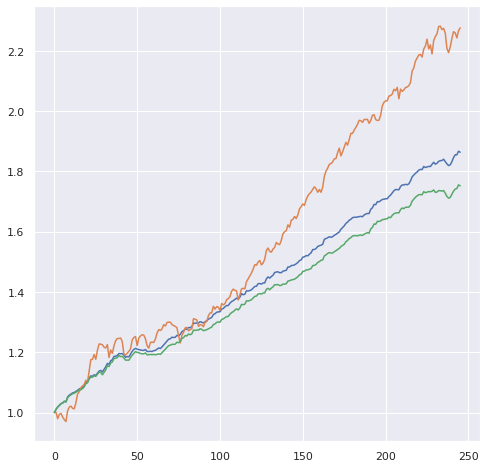

In [14]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(add_return(np.array(all_re)-np.array(market_return)))
plt.plot(add_return(np.array(all_re)))
plt.plot(add_return(np.array(re_limit)-np.array(market_return)))

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


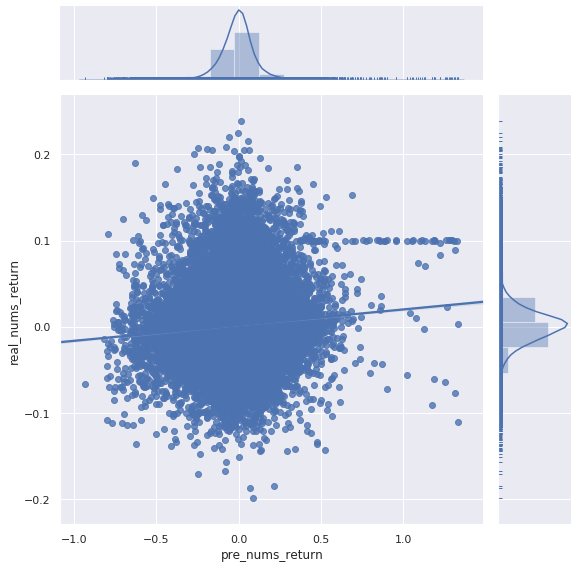

In [15]:

sns.jointplot(
              x = df_r['pre_nums_return'], y = df_r['real_nums_return'],          
              data = df_r,  #设置数据                                 
              kind="reg",                                     
              size = 8, #图表大小(自动调整为正方形))             
              ratio = 5, #散点图与布局图高度比，整型             
              marginal_kws = dict(bins=15, rug =True),              
             )

In [49]:
p1  = data_tr[(data_tr["return"]>0.11) | (data_tr["return"]<-0.11)]
p2  = data_te[(data_te["return"]>0.11) | (data_te["return"]<-0.11)]

In [52]:
(len(p1))/(len(data_tr))

0.00384488922986691

In [51]:
(len(p1) + len(p2))/(len(data_tr) + len(data_te))

0.004145217023377173

In [16]:
def segment_mean(x,y,bins):
    x_range = np.linspace(min(x), max(x), bins)
    df = pd.DataFrame({"x":x, "y":y})
    df["x_cut"] = pd.cut(df["x"], x_range)
    

In [17]:
df_r["real_nums_return"].std()

0.025677576117620265

In [18]:
df_r["real_nums_return"].mean()

0.0016743804144728988

In [19]:
for i in range(10):
    temp_df = df_r[df_r["pre_rank"] == i ]
    print(i, np.corrcoef(temp_df["real_nums_return"] - temp_df["market_return"], temp_df["pre_nums_return"])[0,1])

0 0.04343690817991685
1 0.009888529331354734
2 0.009020246639144391
3 0.020008899647223875
4 0.006461185370340976
5 0.01032654468538619
6 0.023573585829964546
7 0.019942392521264767
8 0.01198134809559011
9 0.09525182063139216


In [20]:
for i in range(10):
    temp_df = df_r[df_r["pre_rank"] == i ]
    print(i, np.corrcoef(temp_df["real_nums_return"], temp_df["pre_nums_return"])[0,1])

0 0.057801370025144405
1 0.017418514783029852
2 -0.003241561689537131
3 -0.00045538461020965134
4 0.0004922433935353068
5 0.012718689455174702
6 0.03066749276329453
7 0.04153130694340745
8 0.04492730635902941
9 0.09652700350733855


In [21]:
np.corrcoef(df_r["rank"], df_r["pre_rank"])[0,1]

0.09514750237122356

In [22]:
np.corrcoef(np.array(all_nums_return) - np.array(all_market_return_list) , all_nums_p_return)[0,1]

0.09085626692406445

In [23]:
np.corrcoef(np.array(all_nums_return) , all_nums_p_return)[0,1]

0.0834015725358172

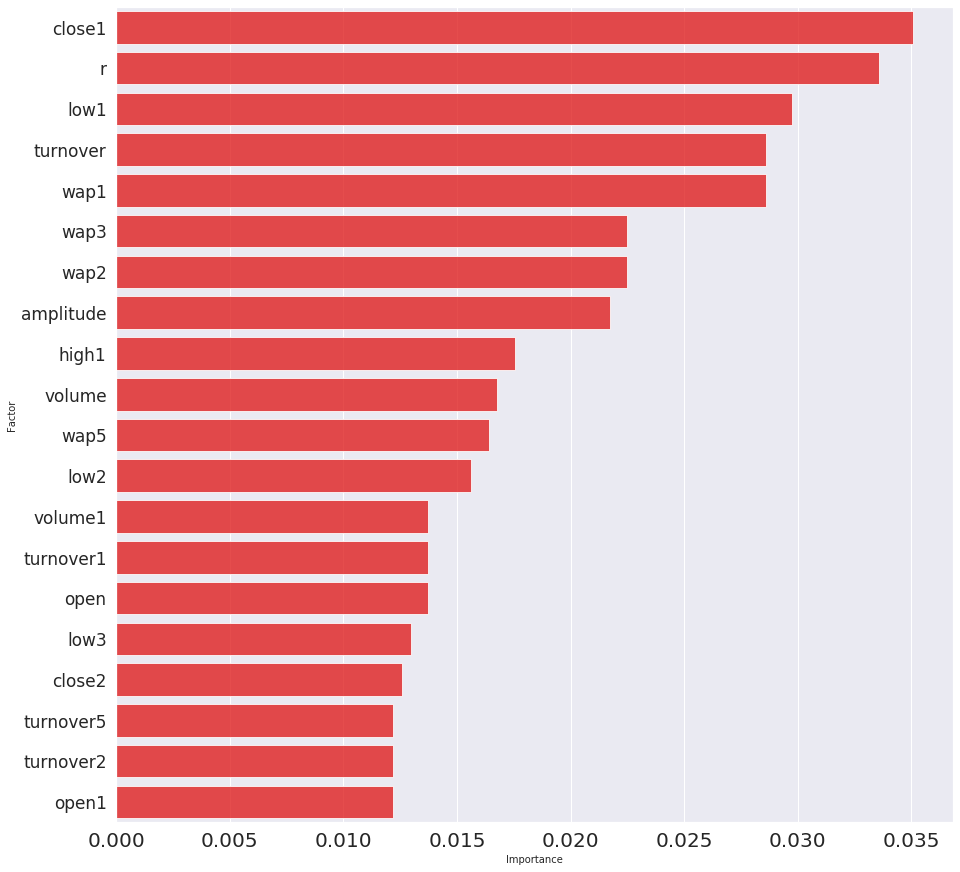

In [24]:
plt.rcParams['figure.figsize'] = (15, 15)
plt.tick_params(labelsize=20)
f_importance_bar(importance_dic)

In [25]:
df_r

,real_nums_return,pre_nums_return,rank,pre_rank,limit_tag,market_return,time_list
0,-0.023552,0.070584,1.0,8,0,-0.010063,2014-01-02
1,-0.009534,-0.058569,5.0,2,0,-0.010063,2014-01-02
2,0.000000,0.070685,6.0,8,0,-0.010063,2014-01-02
3,-0.023729,-0.009853,1.0,4,0,-0.010063,2014-01-02
4,0.026820,-0.083846,9.0,1,0,-0.010063,2014-01-02
...,...,...,...,...,...,...,...
116341,0.013208,0.082686,6.0,7,0,0.012888,2014-12-31
116342,-0.012314,0.074904,2.0,7,0,0.012888,2014-12-31
116343,-0.034688,-0.039249,0.0,2,0,0.012888,2014-12-31
116344,-0.072329,0.068259,0.0,7,0,0.012888,2014-12-31


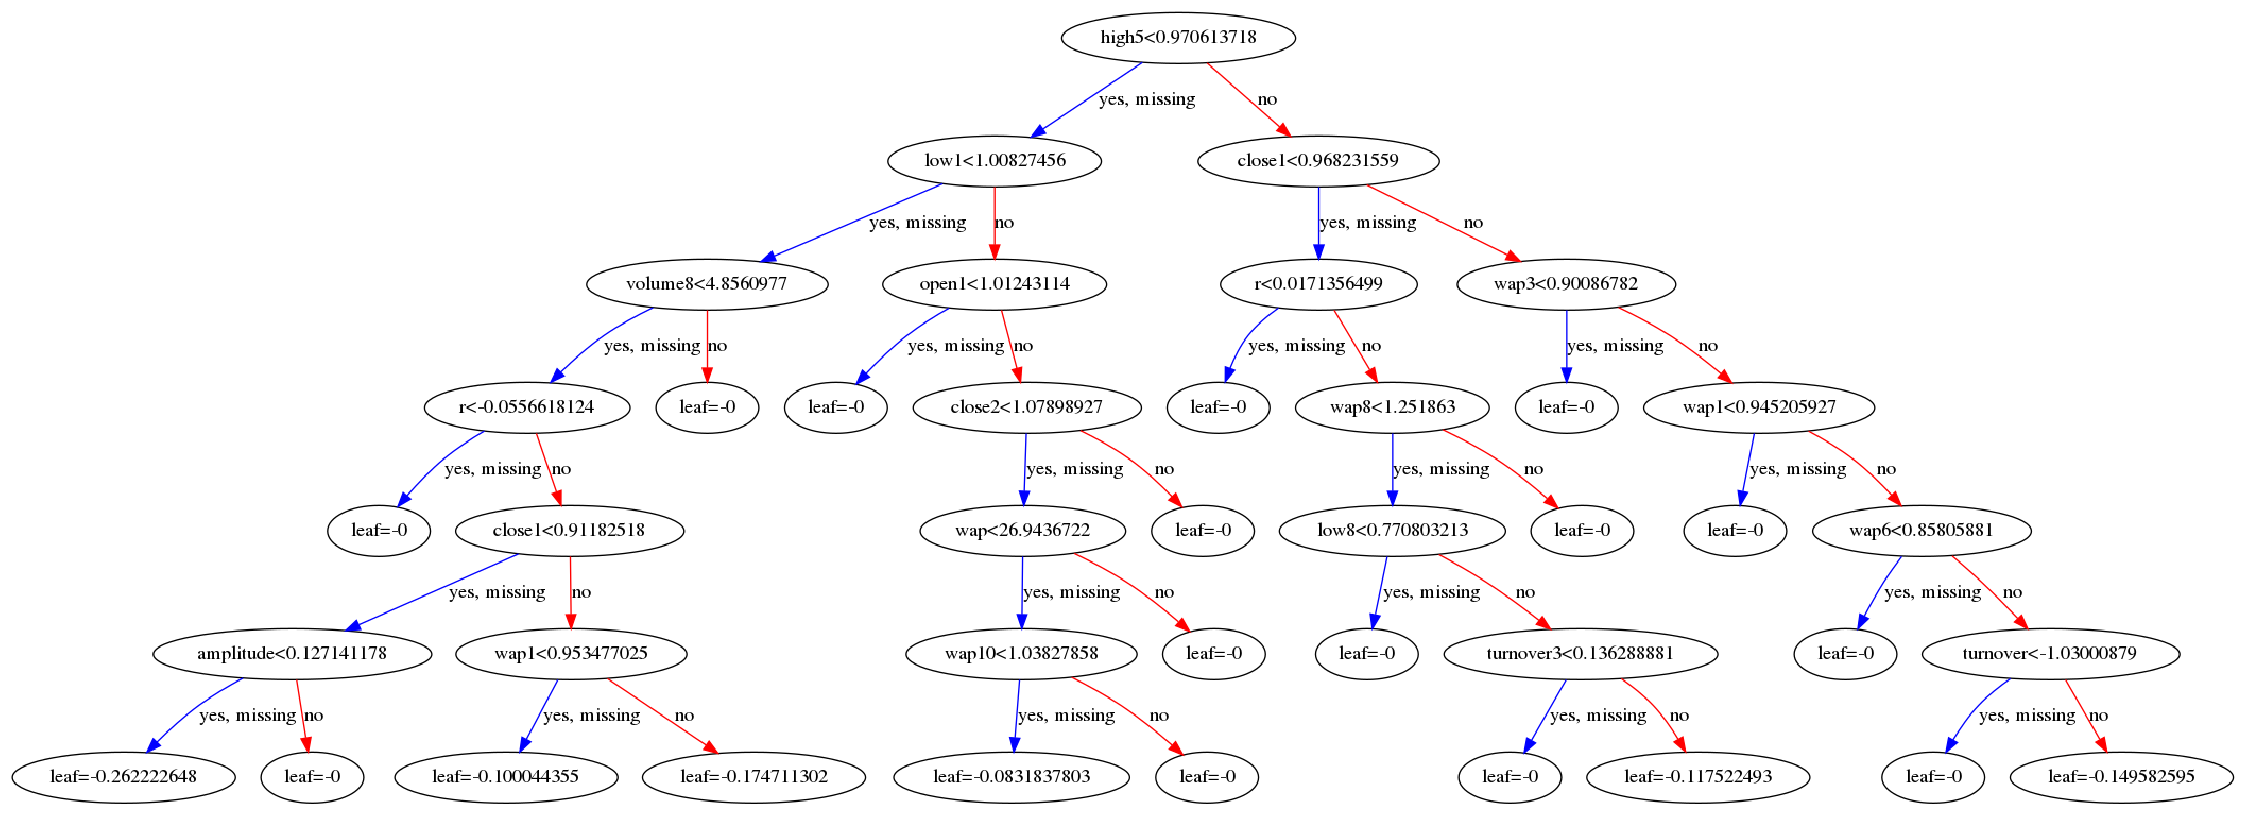

In [26]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=0)
plt.show()

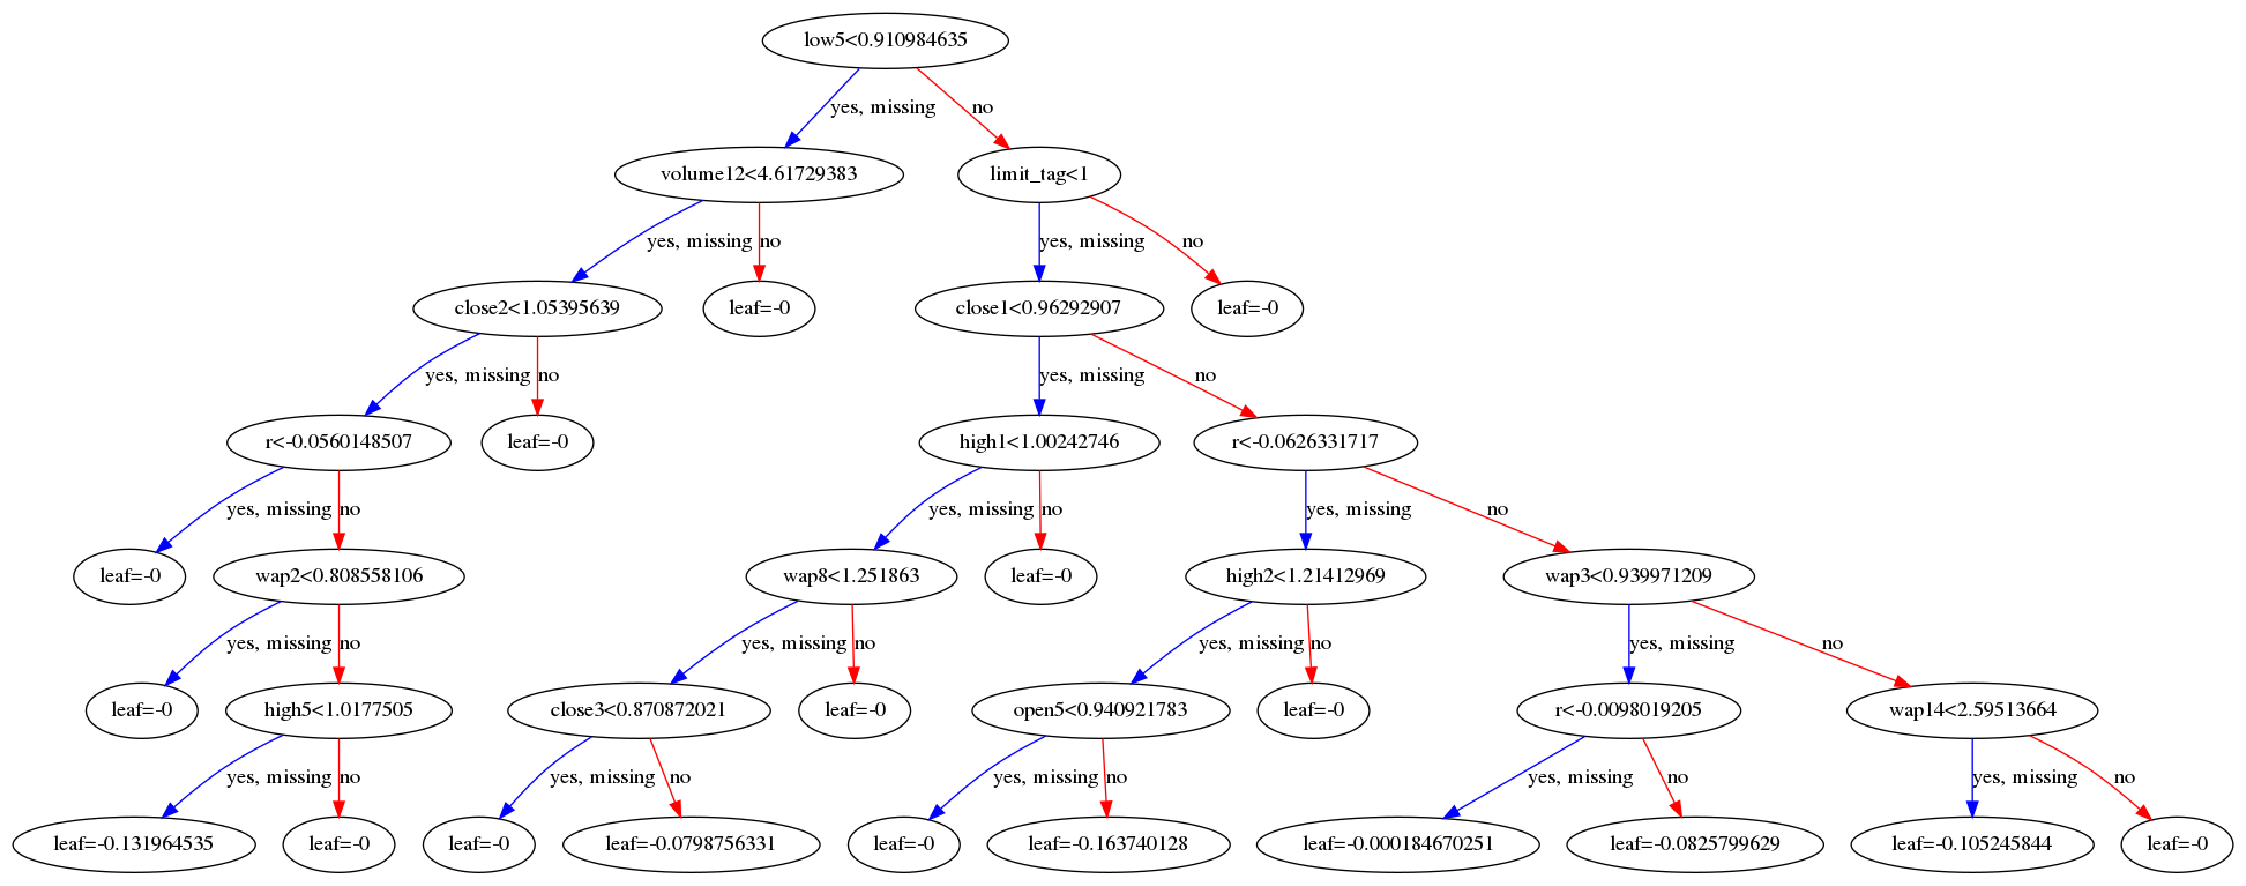

In [27]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=1)
plt.show()

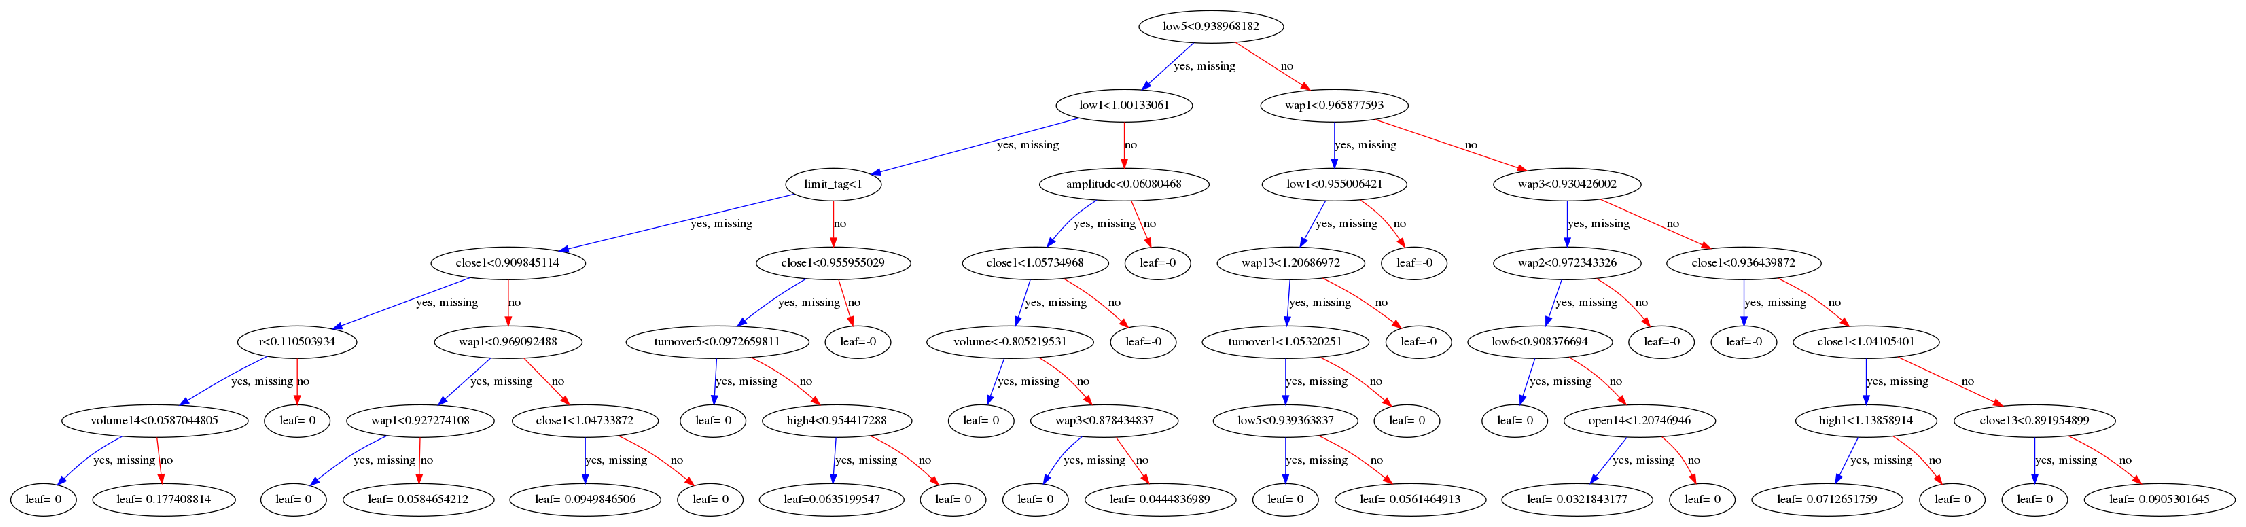

In [28]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=2)
plt.show()

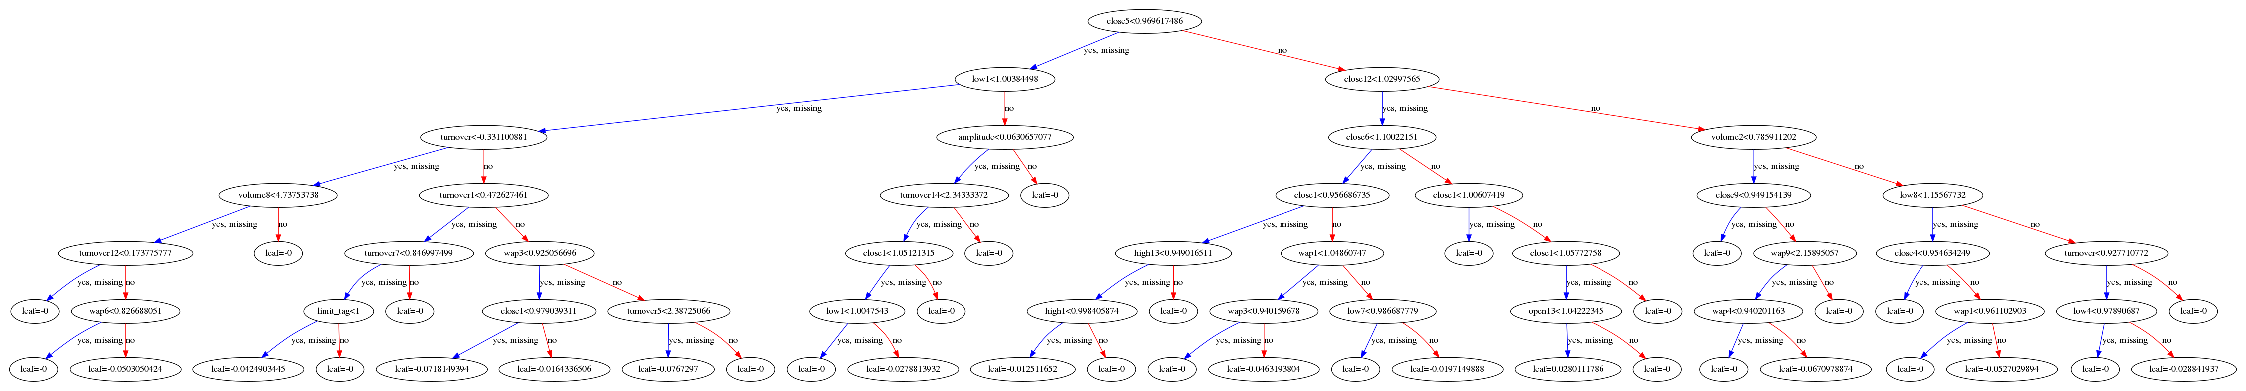

In [29]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=3)
plt.show()

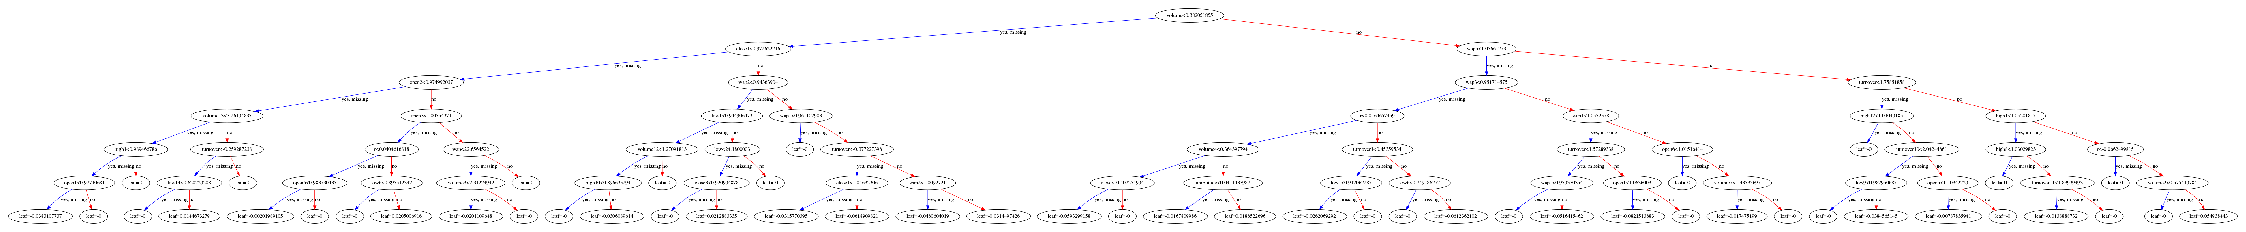

In [30]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=4)
plt.show()

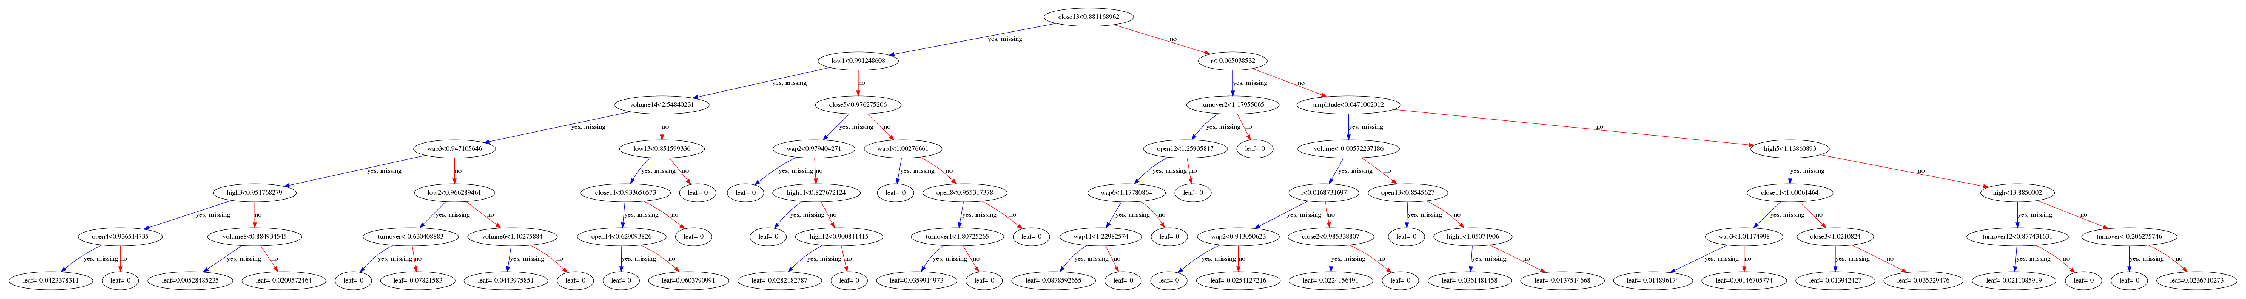

In [31]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=5)
plt.show()

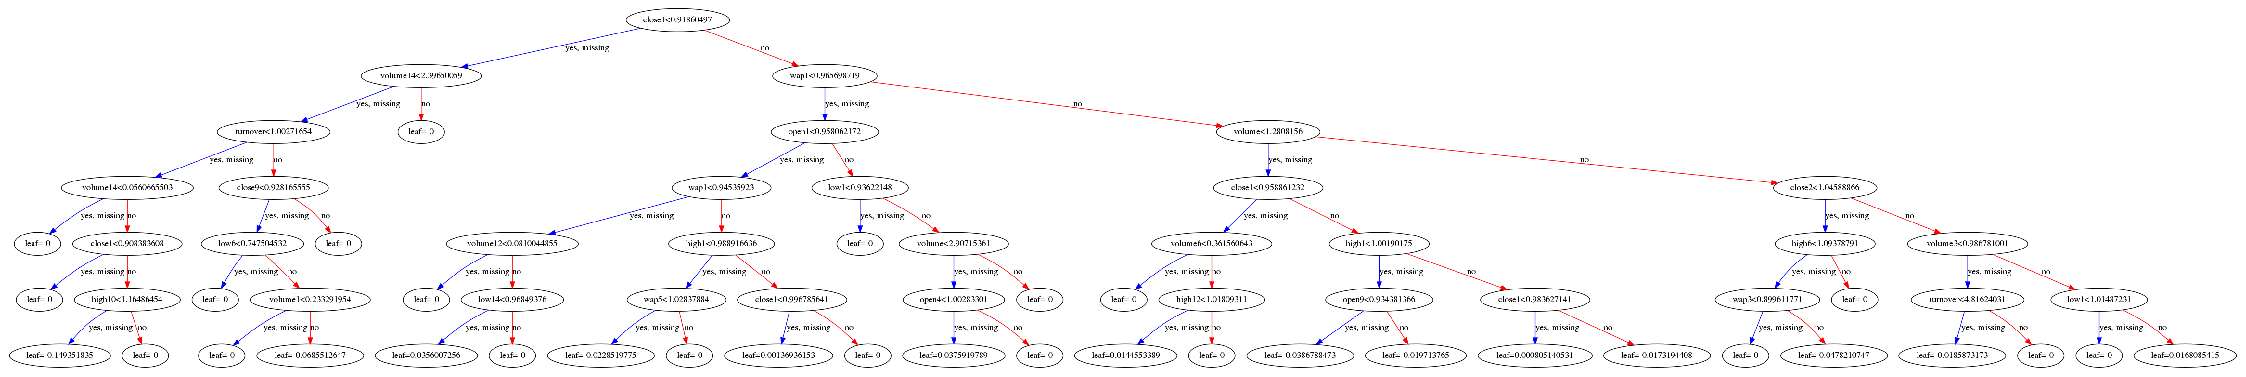

In [32]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=6)
plt.show()

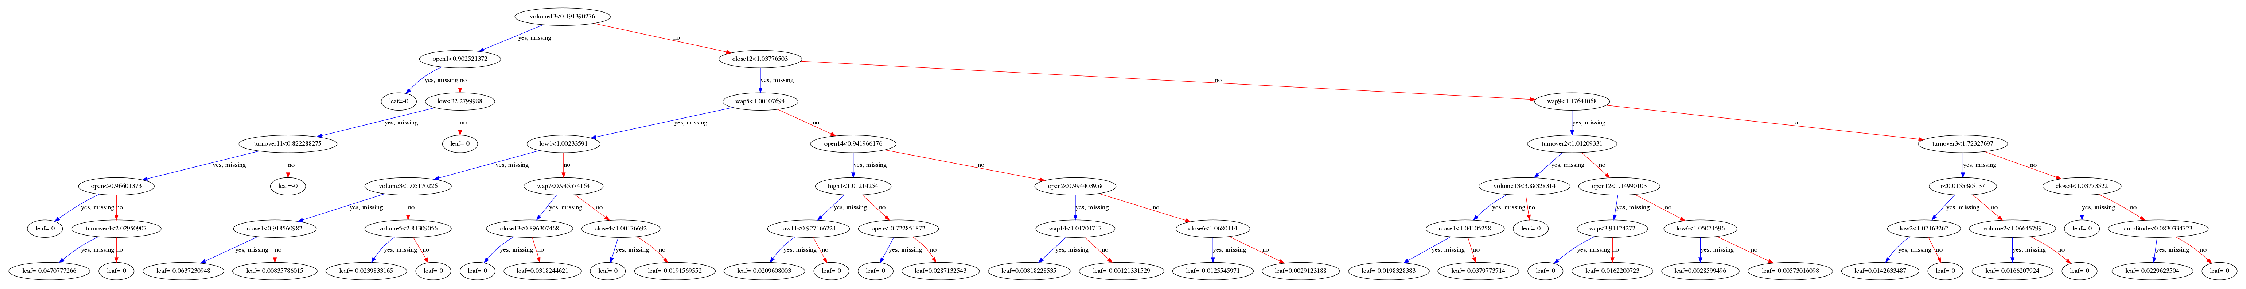

In [33]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=7)
plt.show()

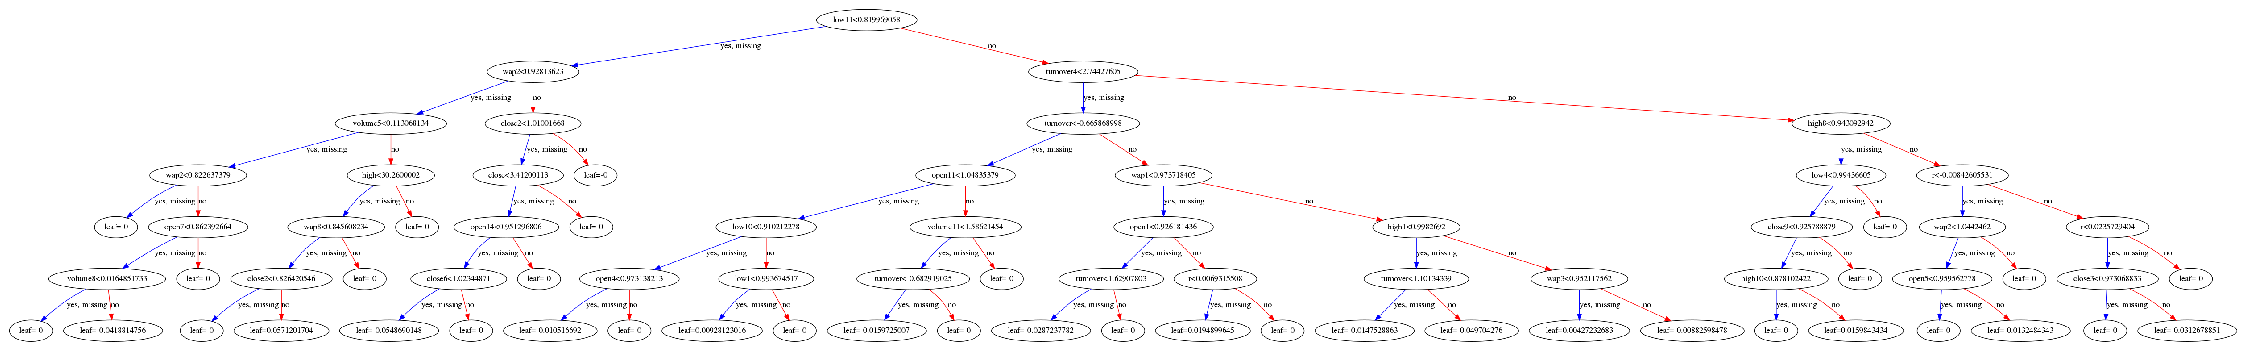

In [34]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=8)
plt.show()

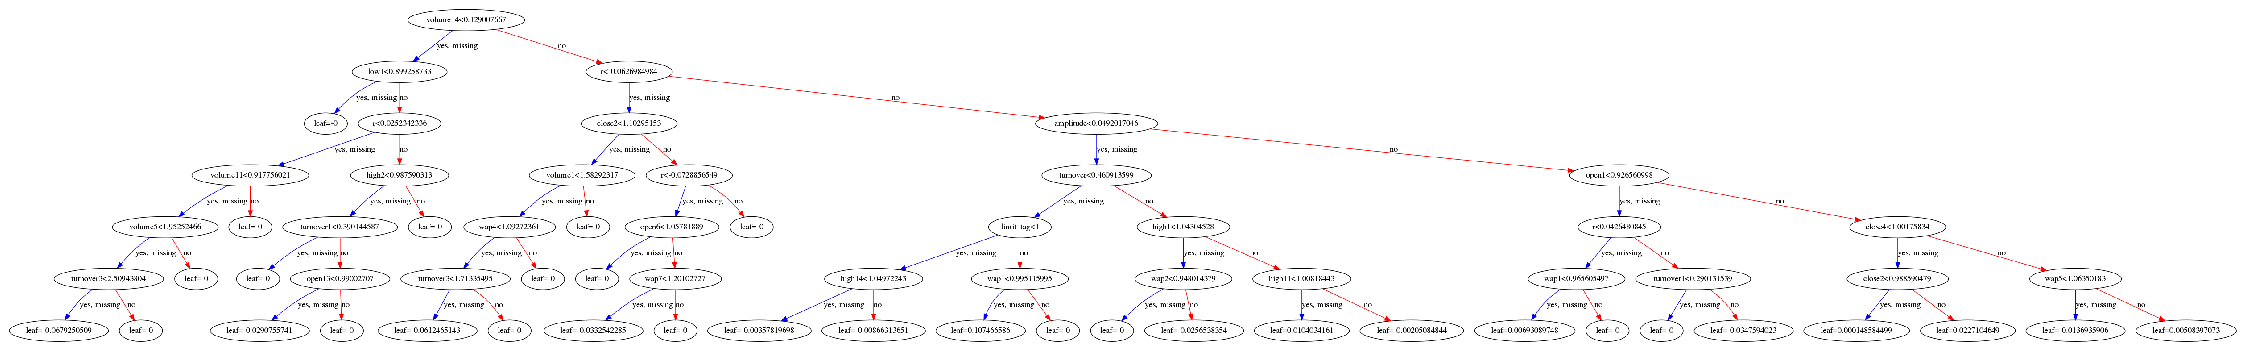

In [35]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=9)
plt.show()

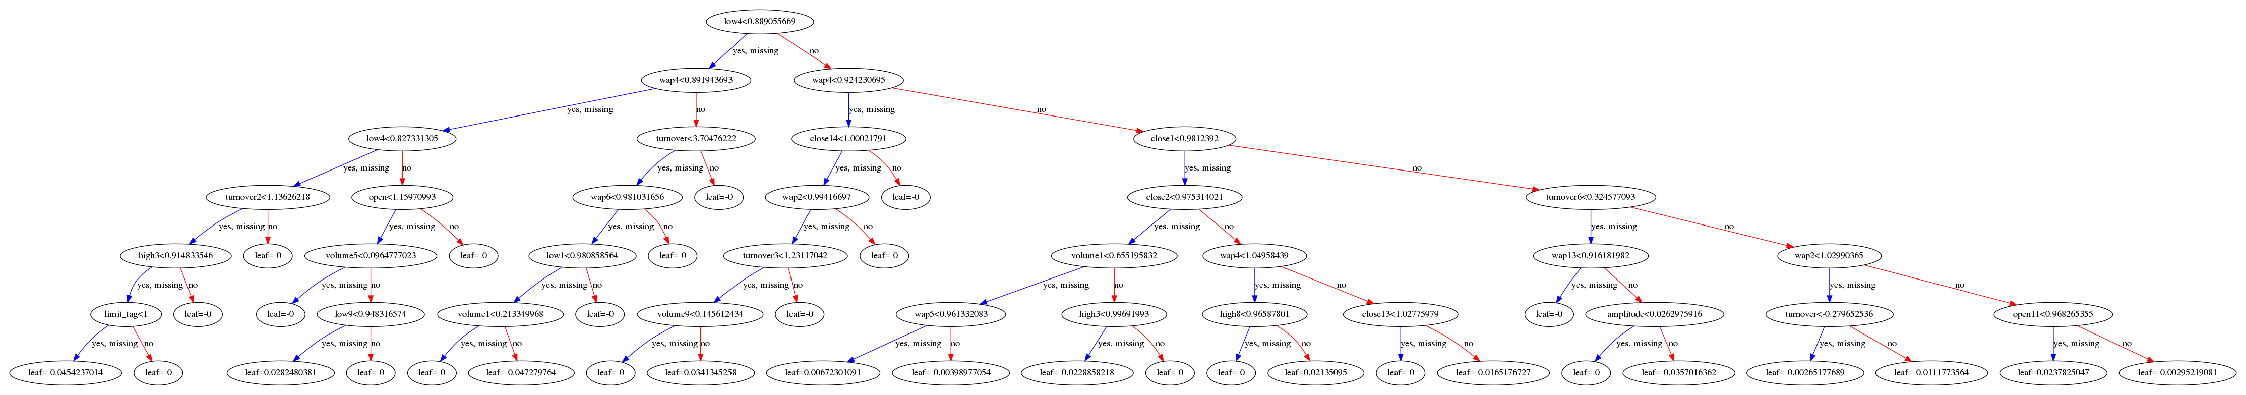

In [36]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=10)
plt.show()

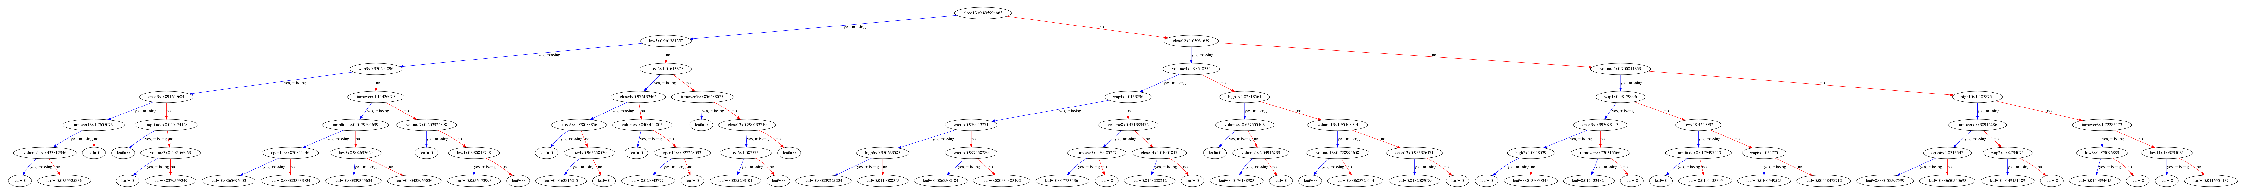

In [37]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=11)
plt.show()

NameError: name 'np' is not defined